Modelo 40:

Seasonal period = 24

fución de activación lstm: tanh

tendencia = 2017-2018 -> init_trend: '2018-01-01 00:00:00'

dropout1 = 0.05   dropout2 = 0.05

epochs = 100

neurons 1 = 64

neurons 2 = 32

activation1 = Relu

activation2 = Relu

bias_initializer = 'ones'


* En este script, voy a prescindir de extrapolar la tendencia y extrapolaré únicamente la estacionalidad del último año para entrenar el modelo. La parte T_t + R_t será el input de la red, más no únicamente R_t. A_t = T_t + R_t corresponde a la serie ajustada por la estacionalidad.

* Hacer la modificación anterior implica cambiar la función get_inputs, de tal manera que devuelva la parte estacional y la tendencia y residuos juntos. Ya no será necesario el parámetro "init_trend", tampoco serán necesarias las funciones extra_season o extra_trend, pues el entrenamiento se realizará entero sobre todo el dataset, pues se separará la estacionalidad de la tendencia y los residuales, siendo estos dos últimos el input de la red.

* Volvemos a seleccionar el rango [0,1] para los inputs de la red


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import scipy.stats as stats
import pylab
from stldecompose import decompose, forecast
from sklearn.metrics import mean_absolute_error

In [2]:
import time
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dropout
from keras.layers.core import Activation
import tensorflow as tf
from keras.layers.core import Lambda #para funcion drop out permanente
from keras import backend as K #para funcion drop out permanente
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Input
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.externals import joblib 

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Clase Preprocesado

In [3]:
def train_box_cox(data):
    
    '''Recibe un conjunto de datos para entrenar transformación de box cox
    '''
    
    transformer = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    box_normalization = transformer.fit(np.array(train).reshape(-1,1))
    
    return box_normalization

def plot_dist_qq(data):
    '''Recibe un conjunto de datos, grafica su distribución y un gráfico QQ'''
    
    fig = plt.figure(figsize=(9, 3))
    plt.subplot(121)
    sns.distplot(data)
    plt.subplot(122)
    stats.probplot(data[0:,0], dist="norm", plot=pylab)
    
    return fig
    
def decompose_data(observed, period):
    
    date = '2014-01-01'
    index = pd.date_range(start=date, periods=len(observed), freq='H')
    serie = pd.DataFrame(data = observed.round(5), columns = ['train'])
    serie.index = index
    serie_decomp = decompose(serie, period = period)
    
    return serie_decomp
    
def plot_decomposition(decomposition):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
    decomposition.observed.plot(ax=ax1)
    decomposition.trend.plot(ax=ax2)
    decomposition.seasonal.plot(ax=ax3)
    decomposition.resid.plot(ax=ax4)
    
    return fig

#def plot_extra_trend(trend, extra_trend):
    
#    fig = plt.figure(figsize=(6, 3))
#    plt.plot(np.concatenate((np.array(trend), extra_trend), axis = 0))
       
#    return fig


#def extra_season(decomposition, init, last):
    
#    return decomposition.seasonal[init:]

#def extra_trend(decomposition, init, periods):
#    
#    '''
#    init: Fecha o índice a partir de donde se tomará la tendencia. Si es fecha debe tener formato: '2018-01-01 00:00:00'
#    periods: el número de periodos de horas a extrapolar, equivalente a la longitud de los datos de validación (o test)
#    
#    '''
#    
#    diff = np.array(decomposition.trend[init:])[0] - np.array(decomposition.trend[init:])
#    new_trend = np.array(decomposition.trend[:])[-1] - diff
#    extra_trend = new_trend[0:periods]
#        
#    return extra_trend
#    
    
def train_MinMax(data):
    
    '''Recibe un conjunto de datos para entrenar transformación de box cox
    '''
    
    scaler = preprocessing.MinMaxScaler()
    minmax_scaler = scaler.fit(data)
    
    return minmax_scaler


def get_inputs(train, validation, period):
    
    train = np.array(train).reshape(-1,1)
    box_cox = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    box_transformer = box_cox.fit(train) 
    train_normalized = box_transformer.transform(train)
    plot_dist_qq(train_normalized)
    
    decompose = decompose_data(train_normalized, period = period)
    plot_decomposition(decompose)
    
    seasonal = decompose.seasonal
    trend = decompose.trend
    resid = decompose.resid
        
    extra_season = seasonal[-len(validation):]
    
    validation_normalized = box_transformer.transform(np.array(validation).reshape(-1,1))
    validation_resid_trend = validation_normalized - extra_season
    validation_resid_trend = validation_normalized - extra_season
    
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    target_scaler = scaler.fit(trend + resid)
    
    train_input = target_scaler.transform(trend + resid)
    validation_input = target_scaler.transform(validation_resid_trend)
    #validation_input[np.where(validation_input < 0)] = 0
    
    dict_return = {'train_input': train_input, 'validation_input': validation_input,
                   'seasonal' : seasonal, 'trend': trend, 'resid': resid,
                   'transformer1': box_transformer, 'transformer2': target_scaler}
    #dict_return = {'train_input': train_input, 'validation_input': validation_input,
    #               'seasonal' : seasonal, 'transformer1': box_transformer, 
    #               'transformer2': target_scaler}
    
    return dict_return

# Clase Bayesian LSTM

In [19]:
class BayesianLSTM():

    def __init__(self):

        self.look_back = 1
        self.batch_size = 1
        self.num_lstm = 1
        self.input_data = []
        self.output_data = []

    def create_dataset(self, dataset, look_back):

        self.look_back = look_back
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back):
            a = dataset[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])

        self.input_data = np.array(dataX)
        self.output_data = np.array(dataY)

        return self.input_data, self.output_data

    def fit_model(self, x, y, num_lstm, epochs, neurons1, neurons2, neurons3,dropout1, dropout2):

        self.num_lstm == num_lstm
        batch_size = self.batch_size

        x = x.reshape(x.shape[0], 1, x.shape[1])

        input = Input(shape=(1, x.shape[2]), batch_shape=(batch_size, x.shape[1], x.shape[2]))
        lstm1 = LSTM(neurons1, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                     stateful=True, 
                     activation="tanh", recurrent_activation="sigmoid",
                     bias_initializer = "ones",
                     kernel_initializer="random_normal")(input)  
        #drop = Dropout(dropout1)(lstm1, training=True)

        if self.num_lstm == 2:
            
            lstm2 = LSTM(neurons2, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                         stateful=True,
                         activation="tanh", recurrent_activation="sigmoid",
                         kernel_initializer="random_normal")(drop)
            drop = Dropout(dropout2)(lstm2, training=True)
            
        if self.num_lstm == 3:
            lstm2 = LSTM(neurons2, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                         stateful=True)(drop)
            drop = Dropout(dropout2)(lstm2, training=True)
            
            lstm3 = LSTM(neurons3, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                         stateful=True)(drop)
            drop = Dropout(dropout2)(lstm3, training=True)

        dense1 = Dense(1)(lstm1)
        out = Activation('relu')(dense1)

        model = Model(inputs=input, outputs=out)
        model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mape'])
        num_epoch = epochs

        for i in range(num_epoch):
            print('epoca:',i)
            model.fit(x, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
            model.reset_states

        return model

    #def bayesian_predict(self, x, n_experiments, model, transform_1, transform_2, season_trend_data):
    def bayesian_predict(self, x, n_experiments, model, transform):
        prediction_df = pd.DataFrame()
        prediction_df['index'] = range(len(x))
        x = x.reshape(x.shape[0], 1, x.shape[1])

        for i in range(n_experiments):
            experiment_predictions = model.predict(x, self.batch_size)
            des_scaled = transform.inverse_transform(experiment_predictions)
            print(i)
            #des_decomp = des_scaled + season_trend_data
            #des_normalized = transform_1.inverse_transform(des_decomp)
            prediction_df['generation_{}'.format(i)] = des_scaled

        df_generation = prediction_df.filter(like='generation', axis=1)
        prediction_df['generation_mean'] = df_generation.mean(axis=1)
        prediction_df['generation_std'] = df_generation.std(axis=1)
        prediction_df = prediction_df[['generation_mean', 'generation_std']]

        return prediction_df
    
    def bayesian_predict2(self, x, n_experiments, model, transform):
        prediction_df = pd.DataFrame()
        prediction_df['index'] = range(len(x))
        x = x.reshape(x.shape[0], 1, x.shape[1])

        for i in range(n_experiments):
            experiment_predictions = model.predict(x, self.batch_size)
            des_scaled = transform.inverse_transform(experiment_predictions)
            print(i)
            #des_decomp = des_scaled + season_trend_data
            #des_normalized = transform_1.inverse_transform(des_decomp)
            prediction_df['generation_{}'.format(i)] = des_scaled

        df_generation = prediction_df.filter(like='generation', axis=1)
        prediction_df['generation_mean'] = df_generation.mean(axis=1)
        prediction_df['generation_median'] = df_generation.median(axis=1)
        prediction_df['generation_std'] = df_generation.std(axis=1)
        prediction_df = prediction_df[['generation_mean', 'generation_median', 'generation_std']]

        return prediction_df
    

    def bayesianLSTM_plot(self, real, y_predicted, init_date):
        
        bayes_predicted = pd.DataFrame()
        bayes_predicted['generation_mean'] = np.array(y_predicted.iloc[0:, 0])
        bayes_predicted['generation_std'] = np.array(y_predicted.iloc[0:, 1])

        date_plot = pd.date_range(init_date, periods=len(bayes_predicted), freq='H')
        df_plot_pred = pd.DataFrame()

        # predicted df
        df_plot_pred['Fecha'] = date_plot
        df_plot_pred['Datos'] = 'Predicción'
        df_plot_pred['Generación Eólica (MW)'] = np.array(bayes_predicted['generation_mean'])

        # real df
        df_plot_real = pd.DataFrame()
        df_plot_real['Fecha'] = date_plot
        df_plot_real['Datos'] = 'Real'
        df_plot_real['Generación Eólica (MW)'] = np.array(real)

        # plot df

        df_plot = pd.concat([df_plot_pred,
                             df_plot_real], axis=0)

        # plot error

        error_df = pd.DataFrame()
        error_df['Fecha'] = date_plot
        error_df['lower_bound'] = np.array(bayes_predicted['generation_mean'] - 3 * bayes_predicted['generation_std'])
        error_df['upper_bound'] = np.array(bayes_predicted['generation_mean'] + 3 * bayes_predicted['generation_std'])

        plt.figure(figsize=(20, 12))
        sns.set_style("white")
        plt.xlabel('Fecha')
        plt.ylabel('Generación')
        plt.fill_between(error_df.Fecha, error_df.lower_bound, error_df.upper_bound,
                         color='gray', alpha=0.2)
        sns.lineplot(x="Fecha", y="Generación Eólica (MW)", hue='Datos',
                     data=df_plot)

    def bayesianLSTM_plot2(self, real, y_predicted, init_date):
        
            bayes_predicted = pd.DataFrame()
            bayes_predicted['generation_mean'] = np.array(y_predicted.iloc[0:, 0])
            bayes_predicted['generation_median'] = np.array(y_predicted.iloc[0:, 1])
            bayes_predicted['generation_std'] = np.array(y_predicted.iloc[0:, 2])

            date_plot = pd.date_range(init_date, periods=len(bayes_predicted), freq='H')
            df_mean_pred = pd.DataFrame()
            df_median_pred = pd.DataFrame()
            
            # mean predicted df 
            df_mean_pred['Fecha'] = date_plot
            df_mean_pred['Datos'] = 'Predicción (Media)'
            df_mean_pred['Generación Eólica (MW)'] = np.array(bayes_predicted['generation_mean'])
            
            # median predicted df 
            df_median_pred['Fecha'] = date_plot
            df_median_pred['Datos'] = 'Predicción (Mediana)'
            df_median_pred['Generación Eólica (MW)'] = np.array(bayes_predicted['generation_median'])

            # real df
            df_plot_real = pd.DataFrame()
            df_plot_real['Fecha'] = date_plot
            df_plot_real['Datos'] = 'Real'
            df_plot_real['Generación Eólica (MW)'] = np.array(real)

            # plot df

            df_plot = pd.concat([df_plot_real,
                                 df_mean_pred,
                                 df_median_pred], axis=0)

            # plot error

            error_df = pd.DataFrame()
            error_df['Fecha'] = date_plot
            error_df['lower_bound'] = np.array(bayes_predicted['generation_mean'] - 3 * bayes_predicted['generation_std'])
            error_df['upper_bound'] = np.array(bayes_predicted['generation_mean'] + 3 * bayes_predicted['generation_std'])
            error_df['middle_lower_bound'] = np.array(bayes_predicted['generation_mean'] - 2 * bayes_predicted['generation_std'])
            error_df['middle_upper_bound'] = np.array(bayes_predicted['generation_mean'] + 2 * bayes_predicted['generation_std'])
            
            
            lower_corrected = [0 if x < 0 else x for x in error_df['lower_bound']]
            error_df['lower_bound'] = np.array(lower_corrected)
            
            middle_lower_corrected = [0 if x < 0 else x for x in error_df['middle_lower_bound']]
            error_df['middle_lower_bound'] = np.array(middle_lower_corrected)
            
                      
            plt.figure(figsize=(17, 9))
            sns.set_style("white")
            plt.title('Predicción Generación Eólica (MW) - Última semana Datos de Validación', fontsize= 25)
            plt.xlabel('Fecha',fontsize = 18)
            plt.ylabel('Generación Eólica (MW)',fontsize = 18)
            plt.xticks(fontsize= 12)
            plt.yticks(fontsize= 12)
            
            plt.fill_between(error_df.Fecha, error_df.lower_bound, error_df.middle_lower_bound,
                             color='gray', alpha=0.10)
                        
            plt.fill_between(error_df.Fecha, error_df.middle_lower_bound, error_df.middle_upper_bound,
                             color='gray', alpha=0.15)
            
            plt.fill_between(error_df.Fecha, error_df.middle_upper_bound, error_df.upper_bound,
                             color='gray', alpha=0.10)
            
           
            g = sns.lineplot(x="Fecha", y="Generación Eólica (MW)", hue='Datos', style="Datos",
                         data=df_plot)
            g.legend(loc='upper right',bbox_to_anchor=(1.175, 1.0),fontsize = 12)
            
            plt.savefig('Pronóstico Eólica Validation-lastweek.pdf',bbox_inches="tight")
            
            
#plt.figure(figsize=(15, 9))
#sns.set_style("white")
#plt.title('Pronóstico Generación Eólica (MW)', fontsize= 25)
##plt.figtext(.5,.9,'División del Dataset', fontsize=30, ha='center')
#plt.xlabel('Fecha', fontsize = 18)
#plt.ylabel('Generación Eólica (MW)', fontsize = 18)
#plt.xticks(fontsize= 12)
#plt.yticks(fontsize= 12)
#g = sns.lineplot(x="Fecha", y="Generación Eólica (MW)", hue='Datos',
#                     data=df_plot)
#g.legend(loc='upper right',bbox_to_anchor=(1.13, 1.0),fontsize = 12)
#plt.savefig('Division_dataset.pdf')

# Clase Metrics

In [5]:
class Metrics():

  def __init__(self):
    pass

  def rmse(real, predicted):
    return sqrt(mean_squared_error(real, predicted))

  def smape(real, predicted):
    return 100*np.sum(np.abs(predicted - real)) / np.sum(predicted + real)

  def mape(real, predicted): 
    return np.mean(np.abs((real - predicted) / real)) * 100

  def mae(real, predicted):
    return mean_absolute_error(real, predicted)

# Clase Naive 

In [6]:
class Naive():
    
    def __init__(self):
        pass
    
    def create_data_set(self, data, len_train):
        
        '''Recibe una serie como input, la cual será dividida en train y test, la división se hará según
        el parámetro que reciba len_train, el cual debe corresponder al tamaño que se espera del conjunto de 
        entrenamiento.
        
        Retorna un dataframe con X siendo la serie original y Y la serie desfasada 1 unidad'''
        
        values = pd.DataFrame(data)
        dataset = pd.concat([values.shift(1), values], axis=1)
        dataset.columns = ['t-1', 't+1']
        dataset = dataset.values
        
        train, test = dataset[1:len_train], dataset[len_train:]
        x_train, y_train = train[:,0], train[:,1]
        x_test, y_test = test[:,0], test[:,1]
        data = {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test }
        
        return data
    
    def model(self, x):
        return x
    
    def prediction(self, data):
        
        predictions = list()
        for x in data:
            yhat = self.model(x)
            predictions.append(yhat)

        return predictions
    


# Tratamiento de datos y pre-procesado

In [7]:
datafile = "C:/Users/hcortazar/Documents/MDS_2019/TFM/TFM code/data_final.npz"
data = np.load(datafile)

In [8]:
train = data['train']
validation = data['validation']
test = data['test']

In [9]:
train_validation = np.concatenate((train,validation))

In [10]:
scaler = preprocessing.MinMaxScaler() #Para modelo Modelo_40_test
scaler = scaler.fit(train_validation.reshape(-1,1)) #Para modelo Modelo_40_test
#scaler = preprocessing.MinMaxScaler()
#scaler = scaler.fit(train.reshape(-1,1))

In [11]:
train_validation_input = scaler.transform(train_validation.reshape(-1,1)) #Para modelo Modelo_40_test
#train_input = scaler.transform(train.reshape(-1,1))

In [12]:
test_input = scaler.transform(test.reshape(-1,1)) #Para modelo Modelo_40_test
#test_input = scaler.transform(validation.reshape(-1,1))

# Modelar y guardar

In [20]:
bayes = BayesianLSTM()

In [14]:
x, y = bayes.create_dataset(np.concatenate((train_validation_input,test_input)), 1) #Para Modelo_40_test
#x, y = bayes.create_dataset(np.concatenate((train_input,test_input)), 1)

In [15]:
x_train, y_train = x[:-len(test_input)], y[:-len(test_input)] #Para Modelo_40_test
x_validation, y_validation = x[-len(test_input):], y[-len(test_input):] #Para Modelo_40_test

#x_train, y_train = x[:-len(test_input):], y[:-len(test_input)] 
#x_validation, y_validation = x[-len(test_input):], y[-len(test_input):] 

In [16]:
len(x_train)

52583

In [16]:
len(x_validation)

3647

In [17]:
model_name = 'modelo_48_test_LSTM.pkl'

In [21]:
t_0 = time.time()
joblib.dump(bayes.fit_model(x = x_train, y = y_train, num_lstm = 1, epochs= 100, neurons1 = 64, neurons2 = 16, neurons3 = 16,
                            dropout1= 0.0, dropout2= 0.00),
            model_name)
t_1 = time.time()

print((t_1 - t_0)/60)

epoca: 0
Epoch 1/1
52583/52583 [==============================] - 121s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 1
Epoch 1/1
52583/52583 [==============================] - 123s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 2
Epoch 1/1
52583/52583 [==============================] - 123s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 3
Epoch 1/1
52583/52583 [==============================] - 124s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 4
Epoch 1/1
52583/52583 [==============================] - 127s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 5
Epoch 1/1
52583/52583 [==============================] - 128s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 6
Epoch 1/1
52583/52583 [==============================] - 119s 2ms/step - loss: 0.1366 - mse: 0.1366 - mape: 99.9981
epoca: 7
Epoch 1/1
26404/52583 [==============>...............] - ETA: 59s - loss: 0.1355 - mse: 0.1355 - mape: 100.0000 

KeyboardInterrupt: 

# Cargar modelo

In [34]:
model = joblib.load(model_name)

# Predecir y Evaluar

### Evaluación en validation

In [45]:
y_hat_validation = bayes.bayesian_predict2(np.concatenate((x_train,x_validation)), 1, model = model, transform= scaler)

0


In [48]:
#Errores sobre validation

mape = Metrics.mape(test, np.array(y_hat_validation.iloc[-len(x_validation):,0].values))
rmse = Metrics.rmse(test, np.array(y_hat_validation.iloc[-len(x_validation):,0].values))
mae = Metrics.mae(test, np.array(y_hat_validation.iloc[-len(x_validation):,0].values))
print('mape modelo: {}   rmse modelo: {}    mae modelo: {}'.format(mape,rmse,mae))

mape modelo: 7.076099664578396   rmse modelo: 451.920222612009    mae modelo: 319.9697071633283


In [38]:
len(x_validation)

3647

In [39]:
len(test)

3647

In [46]:
mape = Metrics.mape(test, np.array(y_hat_validation.iloc[-len(x_validation):,1].values))
rmse = Metrics.rmse(test, np.array(y_hat_validation.iloc[-len(x_validation):,1].values))
mae = Metrics.mae(test, np.array(y_hat_validation.iloc[-len(x_validation):,1].values))
print('mape modelo: {}   rmse modelo: {}    mae modelo: {}'.format(mape,rmse,mae))

mape modelo: 7.076099664578396   rmse modelo: 451.920222612009    mae modelo: 319.9697071633283


In [47]:
mape_train = Metrics.mape(train[1:], np.array(y_hat_validation.iloc[:-len(x_validation),0].values))
rmse_train = Metrics.rmse(train[1:], np.array(y_hat_validation.iloc[:-len(x_validation),0].values))
mae_train = Metrics.mae(train[1:], np.array(y_hat_validation.iloc[:-len(x_validation),0].values))

print('mape train: {}   rmse train: {}    mae train: {}'.format(mape_train,rmse_train,mae_train))

ValueError: operands could not be broadcast together with shapes (43823,) (52583,) 

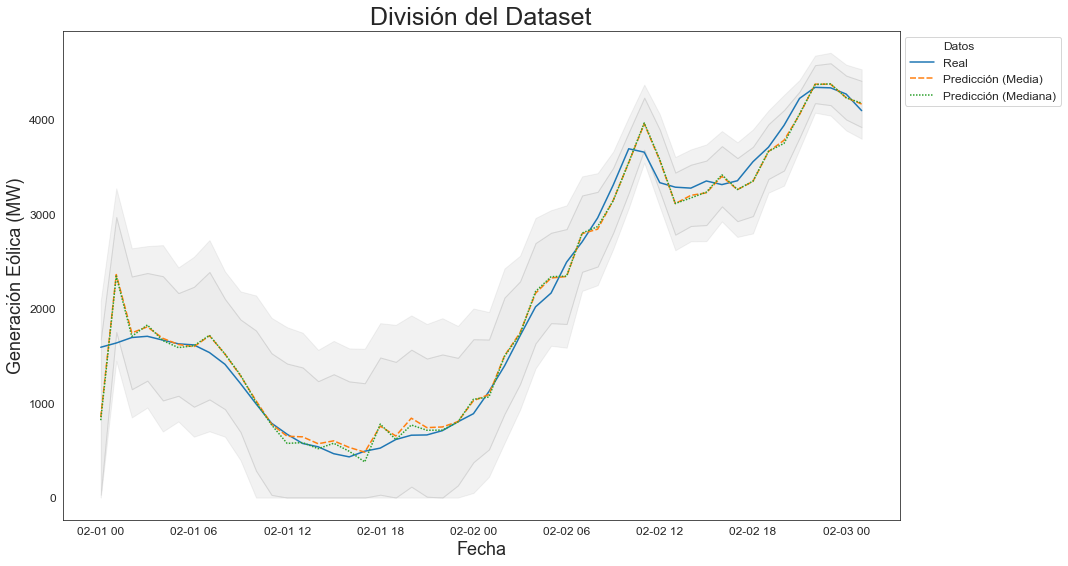

In [177]:
bayes.bayesianLSTM_plot2(np.array(validation[:50]),y_hat_validation[:50],'2020-02-01')

### Evaluación en validation con Naive Model

In [26]:
naive = Naive()

In [27]:
train_validation_naive = np.concatenate((train,validation,test), axis = 0)

In [28]:
data_naive = naive.create_data_set(train_validation_naive, len(train)+len(validation))

In [29]:
x_train_naive = data_naive['x_train']
y_train_naive = data_naive['y_train']

x_test_naive = data_naive['x_test']
y_test_naive = data_naive['y_test']

In [30]:
len(y_test_naive)

3647

In [31]:
y_hat_naive= naive.prediction(x_test_naive)

In [32]:
mape_naive = Metrics.mape(test, y_hat_naive)
rmse_naive = Metrics.rmse(test, y_hat_naive)
mae_naive = Metrics.mae(test, y_hat_naive)
print('mape modelo: {}   rmse modelo: {}    mae modelo: {}'.format(mape_naive,rmse_naive,mae_naive))

mape modelo: 6.246657481316855   rmse modelo: 369.78920391272425    mae modelo: 277.90672004387164


# Conclusiones:

Red Neuronal Final con mediana predicción de test -TEST:

mape modelo: 5.557390364393868   
rmse modelo: 418.5406326006628    
mae modelo: 298.75803136842194

Red Neuronal Final con media predicción de train -TEST:

mape en train: NA    
rmse en train: NA    
mae en train: NA

Red Neuronal Validación con media predicción de validation -VALIDATION:

mape modelo:   
rmse modelo:    
mae modelo:

Red Neuronal Validación con media predicción de train -VALIDATION:

mape train:  
rmse train:    
mae train: 

#### Por lo anterior, se puede decir que: 

Modelo Naive Final sobre TEST:

mape modelo: 6.246657481316855   
rmse modelo: 369.78920391272425
mae modelo: 369.78920391272425

Modelo Naive Final sobre VALIDATION:

mape modelo: 6.246657481316855   
rmse modelo: 369.78920391272425    
mae modelo: 277.90672004387164

# Ahora medir la calidad de la incertidumbre

In [ ]:
bounds_df = pd.DataFrame()

# Using 99% confidence bounds
bounds_df['lower_bound'] = test_uncertainty_plot_df['lower_bound']
bounds_df['prediction'] = test_uncertainty_plot_df['log_energy_consumption_mean']
bounds_df['real_value'] = truth_uncertainty_plot_df['log_energy_consumption']
bounds_df['upper_bound'] = test_uncertainty_plot_df['upper_bound']

bounds_df['contained'] = ((bounds_df['real_value'] >= bounds_df['lower_bound']) &
                          (bounds_df['real_value'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

In [56]:
y_hat_validation

,generation_mean,generation_std
0,13641.388672,908.018372
1,9319.507812,390.871979
2,10607.530273,419.082550
3,10119.757812,328.243225
4,10206.278320,344.272400
5,9953.979492,314.687103
6,9450.442383,311.451843
7,9398.833984,287.750549
8,9654.207031,317.650360
9,8146.419922,179.636627


In [60]:
len(y_hat_validation)

56230

In [61]:
len(train)+len(validation)+len(test)

56231

In [67]:
y_hat_validation.iloc[0:24,0]

0     13641.388672
1      9319.507812
2     10607.530273
3     10119.757812
4     10206.278320
5      9953.979492
6      9450.442383
7      9398.833984
8      9654.207031
9      8146.419922
10     8717.752930
11     9689.630859
12    10238.207031
13    10477.262695
14    10451.934570
15    10991.566406
16    10906.780273
17    11710.683594
18    11232.096680
19    11477.199219
20    11776.257812
21    11677.451172
22    12096.539062
23    12538.980469
Name: generation_mean, dtype: float32

In [41]:
bounds_df = pd.DataFrame()

bounds_df['lower_bound'] = y_hat_validation.iloc[-len(test):,0] - 3*y_hat_validation.iloc[-len(test):,2]
bounds_df['upper_bound'] = y_hat_validation.iloc[-len(test):,0] + 3*y_hat_validation.iloc[-len(test):,2]
bounds_df['real'] = np.array(test)
bounds_df['contained'] = ((bounds_df['real'] >= bounds_df['lower_bound']) &
                          (bounds_df['real'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

Proportion of points contained within 99% confidence interval: 0.927611735673156
